In [1]:
import torch

In [2]:
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer, logging

In [3]:
from PIL import Image
from tqdm import tqdm

In [4]:
torch_device = "cuda:0"

In [20]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14", additional_special_tokens=["<CS>"]
)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet"
)

# The noise scheduler
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.7.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.mlp.fc2.weight', 'vision_model.encoder.layers.15.mlp.fc2.bias', 'vision_model.encoder.layers.10.layer_norm1.bias', 'vision_model.encoder.layers.4.layer_norm2.bias', 'vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.self_attn.q_proj.weight', 'vision_model.encoder.layers.13.mlp.fc2.weight', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.6.layer_norm2.weight', 'vision_model.encoder.layers.2.mlp.fc2.bias', 'vision_model.encoder.layers.2.layer_norm1.bias', 'vision_model.encoder.layers.4.mlp.fc2.bias', 'vision_model.encoder.layers.22.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.self_at

In [6]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)

In [7]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(
        bsz, seq_len, dtype=input_embeddings.dtype
    )

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None,  # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True,  # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [8]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)


def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [9]:
def generate_with_embs(text_embeddings, text_input):
    height = 512  # default height of Stable Diffusion
    width = 512  # default width of Stable Diffusion
    num_inference_steps = 30  # Number of denoising steps
    guidance_scale = 7.5  # Scale for classifier-free guidance
    generator = torch.manual_seed(
        32
    )  # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(
                latent_model_input, t, encoder_hidden_states=text_embeddings
            )["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        )

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [10]:
birb_embed = torch.load("./concept_libs/birb_style.bin")
birb_embed.keys(), birb_embed["<birb-style>"].shape

(dict_keys(['<birb-style>']), torch.Size([768]))

In [21]:
prompt = "A mouse in the style of <CS>"
text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)

In [25]:
text_input.input_ids[0]

tensor([49406,   320,  9301,   530,   518,  1844,   539, 49408, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [26]:
tokenizer.encode("S")
for token in text_input.input_ids[0][:10]:
    print(token, tokenizer.decode(token))

tensor(49406) <|startoftext|>
tensor(320) a
tensor(9301) mouse
tensor(530) in
tensor(518) the
tensor(1844) style
tensor(539) of
tensor(49408) <CS>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [22]:
input_ids = text_input.input_ids.to(torch_device)

In [28]:
input_ids

tensor([[49406,   320,  9301,   530,   518,  1844,   539,  6829, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]], device='cuda:0')

In [23]:
token_embeddings = token_emb_layer(input_ids)

In [27]:
token_embeddings.shape

torch.Size([1, 77, 768])

In [33]:
replacement_token_embedding = birb_embed["<birb-style>"].to(torch_device)

In [35]:
token_embeddings + (replacement_token_embedding * 0.1)

tensor([[[ 0.0181,  0.0041,  0.0080,  ...,  0.0086,  0.0100,  0.0121],
         [ 0.0183, -0.0002, -0.0049,  ..., -0.0020,  0.0217,  0.0182],
         [ 0.0081,  0.0111,  0.0169,  ..., -0.0100,  0.0195,  0.0179],
         ...,
         [ 0.0182,  0.0086,  0.0066,  ...,  0.0089,  0.0106,  0.0154],
         [ 0.0182,  0.0086,  0.0066,  ...,  0.0089,  0.0106,  0.0154],
         [ 0.0182,  0.0086,  0.0066,  ...,  0.0089,  0.0106,  0.0154]]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [12]:
birb_embed["<birb-style>"].shape

torch.Size([768])

In [31]:
tokenizer.added_tokens_encoder

{'<CS>': 49408}

In [1]:
prompt = "A mouse in the style of puppy"

# Tokenize
text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = birb_embed["<birb-style>"].to(torch_device)

# Insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0] == 9301)] = replacement_token_embedding.to(
    torch_device
)
# token_embeddings = token_embeddings + (replacement_token_embedding * 0.9)
# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
generate_with_embs(modified_output_embeddings, text_input)

NameError: name 'tokenizer' is not defined

In [22]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(
        images[:, 1] - 0.9
    )  # [:,2] -> all images in batch, only the blue channel
    error1 = torch.abs(images[:, 0] - 0.9).mean()
    error2 = torch.abs(images[:, 2] - 0.9).mean()
    return torch.sin(error).mean()

In [23]:
def generate_image():
    prompt = "A campfire (oil on canvas)"  # @param
    height = 512  # default height of Stable Diffusion
    width = 512  # default width of Stable Diffusion
    num_inference_steps = 50  # @param           # Number of denoising steps
    guidance_scale = 8  # @param               # Scale for classifier-free guidance
    generator = torch.manual_seed(
        32
    )  # Seed generator to create the inital latent noise
    batch_size = 1
    blue_loss_scale = 200  # @param

    # Prep text
    text_input = tokenizer(
        [prompt],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    # And the uncond. input as before:
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(
                latent_model_input, t, encoder_hidden_states=text_embeddings
            )["sample"]

        # perform CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        )

        #### ADDITIONAL GUIDANCE ###
        if i % 5 == 0:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            # latents_x0 = latents - sigma * noise_pred
            latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = (
                vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5
            )  # range (0, 1)

            # Calculate loss
            loss = blue_loss(denoised_images) * blue_loss_scale

            # Occasionally print it out
            if i % 10 == 0:
                print(i, "loss:", loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2
            scheduler._step_index = scheduler._step_index - 1

        # Now step with scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [24]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(
        images[:, 1] - 0.9
    )  # [:,2] -> all images in batch, only the blue channel
    error1 = torch.abs(images[:, 0] - 0.9).mean()
    error2 = torch.abs(images[:, 2] - 0.9).mean()
    return torch.sin(error).mean()

/tmp/ipykernel_1379210/2827366090.py:41: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  4%|▍         | 2/50 [00:00<00:08,  5.34it/s]

0 loss: 143.9575653076172


 22%|██▏       | 11/50 [00:01<00:07,  5.02it/s]

10 loss: 38.125301361083984


 42%|████▏     | 21/50 [00:03<00:05,  4.94it/s]

20 loss: 19.74921226501465


 62%|██████▏   | 31/50 [00:05<00:03,  5.12it/s]

30 loss: 16.763145446777344


 78%|███████▊  | 39/50 [00:06<00:02,  5.03it/s]

 82%|████████▏ | 41/50 [00:07<00:01,  4.55it/s]

40 loss: 16.04977035522461


100%|██████████| 50/50 [00:08<00:00,  5.58it/s]


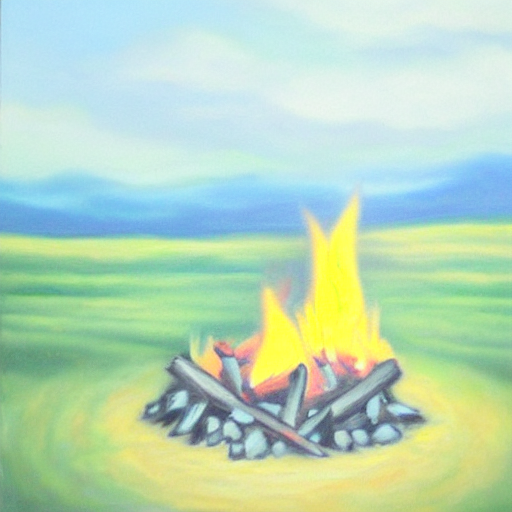

In [25]:
generate_image()

/tmp/ipykernel_1379210/2827366090.py:41: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  4%|▍         | 2/50 [00:00<00:09,  5.21it/s]

0 loss: 161.25640869140625


 18%|█▊        | 9/50 [00:01<00:07,  5.81it/s]

 22%|██▏       | 11/50 [00:02<00:07,  4.98it/s]

10 loss: 14.99917221069336


 42%|████▏     | 21/50 [00:03<00:05,  5.03it/s]

20 loss: 6.336381435394287


 62%|██████▏   | 31/50 [00:05<00:03,  5.07it/s]

30 loss: 5.346101760864258


 82%|████████▏ | 41/50 [00:07<00:01,  5.33it/s]

40 loss: 5.154719829559326


100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


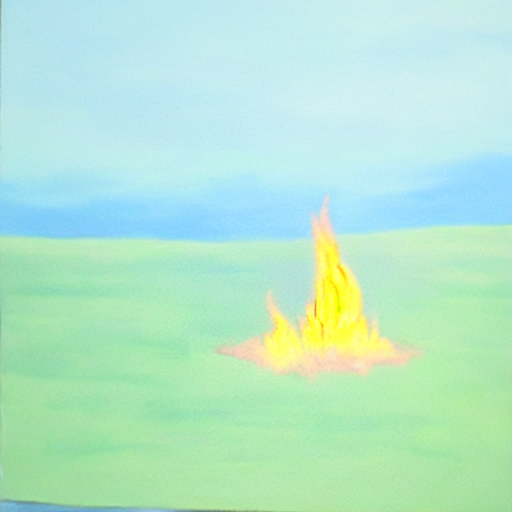

In [26]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(
        images[:, 1] - 0.9
    )  # [:,2] -> all images in batch, only the blue channel
    error1 = torch.abs(images[:, 0] - 0.9).mean()
    error2 = torch.abs(images[:, 2] - 0.9).mean()
    return error.mean()


generate_image()

/tmp/ipykernel_1379210/2827366090.py:41: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  4%|▍         | 2/50 [00:00<00:10,  4.72it/s]

0 loss: 67.99638366699219


  8%|▊         | 4/50 [00:00<00:07,  6.09it/s]

 22%|██▏       | 11/50 [00:02<00:07,  4.95it/s]

10 loss: 2.502936601638794


 42%|████▏     | 21/50 [00:03<00:05,  4.99it/s]

20 loss: 1.4835797548294067


 62%|██████▏   | 31/50 [00:05<00:03,  5.06it/s]

30 loss: 1.431213140487671


 82%|████████▏ | 41/50 [00:07<00:01,  5.06it/s]

40 loss: 1.5110175609588623


100%|██████████| 50/50 [00:08<00:00,  5.57it/s]


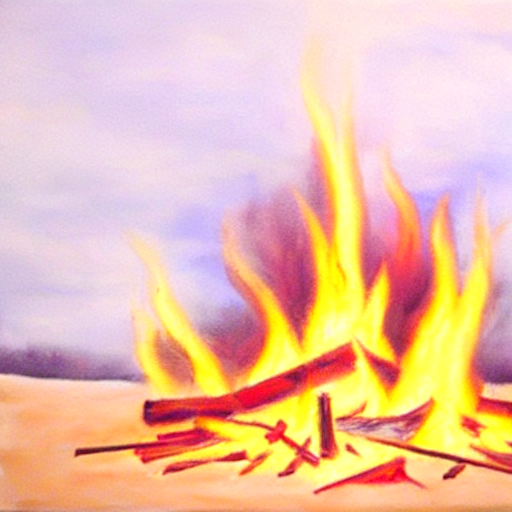

In [27]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(
        images[:, 1] - 0.9
    )  # [:,2] -> all images in batch, only the blue channel
    error1 = torch.abs(images[:, 0] - 0.9)
    error2 = torch.abs(images[:, 1] - 0.9)
    error3 = torch.abs(images[:, 2] - 0.9)
    return torch.sin((error1 * error2 * error3)).mean()


generate_image()

/tmp/ipykernel_1379210/2827366090.py:41: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  2%|▏         | 1/50 [00:00<00:13,  3.58it/s]

0 loss: 96.86041259765625


 20%|██        | 10/50 [00:01<00:06,  6.41it/s]

 24%|██▍       | 12/50 [00:02<00:06,  5.62it/s]

10 loss: 28.76015853881836


 44%|████▍     | 22/50 [00:04<00:05,  5.12it/s]

20 loss: 30.502614974975586


 62%|██████▏   | 31/50 [00:05<00:04,  4.29it/s]

30 loss: 26.043193817138672


 82%|████████▏ | 41/50 [00:09<00:04,  2.21it/s]

40 loss: 23.109338760375977


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


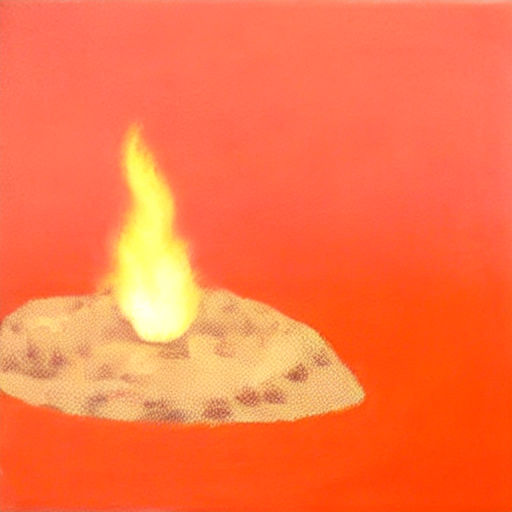

In [28]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(
        images[:, 1] - 0.9
    )  # [:,2] -> all images in batch, only the blue channel
    error1 = torch.abs(images[:, 0] - 0.9).mean()
    error2 = torch.abs(images[:, 2] - 0.9).mean()
    return error1.mean()


generate_image()

/tmp/ipykernel_1379210/2827366090.py:41: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  4%|▍         | 2/50 [00:00<00:09,  5.05it/s]

0 loss: 93.11296081542969


 24%|██▍       | 12/50 [00:02<00:06,  5.51it/s]

10 loss: 31.714460372924805


 42%|████▏     | 21/50 [00:03<00:06,  4.64it/s]

20 loss: 16.27360725402832


 62%|██████▏   | 31/50 [00:05<00:03,  5.07it/s]

30 loss: 14.363956451416016


 82%|████████▏ | 41/50 [00:07<00:01,  5.07it/s]

40 loss: 13.135693550109863


100%|██████████| 50/50 [00:08<00:00,  5.62it/s]


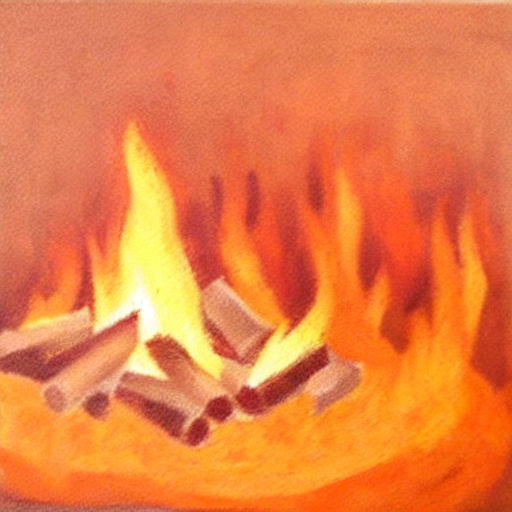

In [29]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(
        images[:, 1] - 0.9
    )  # [:,2] -> all images in batch, only the blue channel
    error1 = torch.abs(images[:, 0] - 0.9).mean()
    error2 = torch.abs(images[:, 2] - 0.9).mean()
    return torch.sin(error1).mean()


generate_image()

/tmp/ipykernel_1379210/2827366090.py:41: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  2%|▏         | 1/50 [00:00<00:13,  3.58it/s]

0 loss: 287.285888671875


 24%|██▍       | 12/50 [00:02<00:06,  5.90it/s]

10 loss: 202.69674682617188


 42%|████▏     | 21/50 [00:03<00:06,  4.82it/s]

20 loss: 200.88429260253906


 62%|██████▏   | 31/50 [00:05<00:03,  4.88it/s]

30 loss: 200.82720947265625


 82%|████████▏ | 41/50 [00:07<00:01,  4.83it/s]

40 loss: 200.82025146484375


100%|██████████| 50/50 [00:08<00:00,  5.64it/s]


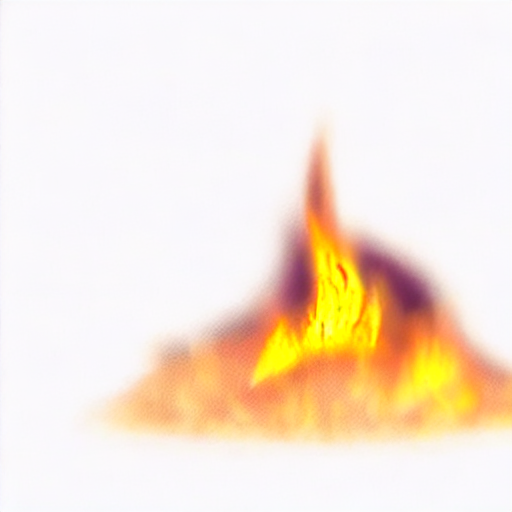

In [30]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(
        images[:, 1] - 0.9
    )  # [:,2] -> all images in batch, only the blue channel
    error1 = torch.abs(images[:, 0] - 0.9)
    error2 = torch.abs(images[:, 1] - 0.9)
    error3 = torch.abs(images[:, 2] - 0.9)
    return torch.abs(torch.exp((error1 * error2 * error3))).mean()


generate_image()

/tmp/ipykernel_1379210/2827366090.py:41: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  2%|▏         | 1/50 [00:00<00:13,  3.72it/s]

0 loss: 253.67300415039062


 22%|██▏       | 11/50 [00:02<00:07,  5.22it/s]

10 loss: 207.44371032714844


 44%|████▍     | 22/50 [00:04<00:05,  5.34it/s]

20 loss: 204.68165588378906


 62%|██████▏   | 31/50 [00:05<00:04,  4.68it/s]

30 loss: 204.14622497558594


 82%|████████▏ | 41/50 [00:07<00:01,  4.80it/s]

40 loss: 204.26516723632812


100%|██████████| 50/50 [00:08<00:00,  5.62it/s]


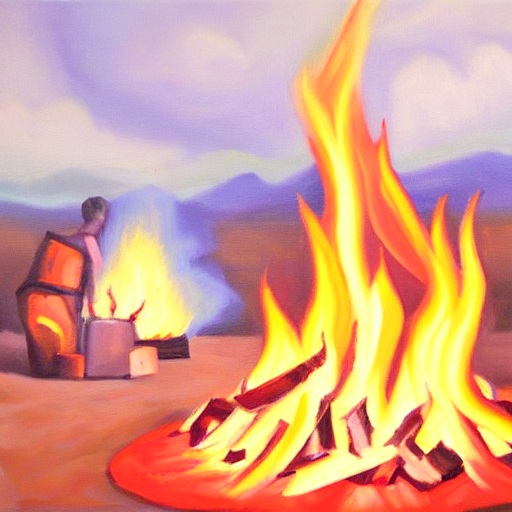

In [31]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(
        images[:, 1] - 0.9
    )  # [:,2] -> all images in batch, only the blue channel
    error1 = torch.abs(images[:, 0] - 0.9)
    error2 = torch.abs(images[:, 1] - 0.9)
    error3 = torch.abs(images[:, 2] - 0.9)
    return (
        torch.sin((error1 * error2 * error3)).mean()
        + torch.cos((error1 * error2 * error3)).mean()
    )


generate_image()

/tmp/ipykernel_1379210/2827366090.py:41: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  2%|▏         | 1/50 [00:00<00:15,  3.17it/s]

0 loss: 0.0


 22%|██▏       | 11/50 [00:02<00:08,  4.86it/s]

10 loss: 0.0


 44%|████▍     | 22/50 [00:04<00:04,  5.63it/s]

20 loss: 0.0


 62%|██████▏   | 31/50 [00:06<00:04,  4.58it/s]

30 loss: 0.0


 78%|███████▊  | 39/50 [00:07<00:01,  5.65it/s]

 82%|████████▏ | 41/50 [00:07<00:01,  4.62it/s]

40 loss: 0.0


100%|██████████| 50/50 [00:09<00:00,  5.32it/s]


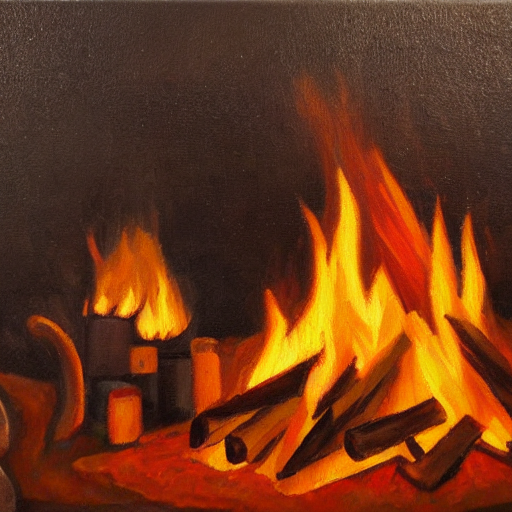

In [32]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(
        images[:, 1] - 0.9
    )  # [:,2] -> all images in batch, only the blue channel
    error1 = torch.abs(images[:, 0] - 0.9)
    error2 = torch.abs(images[:, 1] - 0.9)
    error3 = torch.abs(images[:, 2] - 0.9)
    return 0.0 / error1.mean()


generate_image()

In [33]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(
        images[:, 1] - 0.9
    )  # [:,2] -> all images in batch, only the blue channel
    error1 = torch.abs(images[:, 0] - 0.9)
    error2 = torch.abs(images[:, 1] - 0.9)
    error3 = torch.abs(images[:, 2] - 0.9)
    return (
        torch.abs(torch.sin((error1 + error2 + error3))).mean()
        + torch.abs(torch.cos((error1 + error2 + error3))).mean()
    )


generate_image()

/tmp/ipykernel_1379210/2827366090.py:41: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  2%|▏         | 1/50 [00:00<00:13,  3.66it/s]

0 loss: 273.5631103515625


 20%|██        | 10/50 [00:01<00:06,  6.13it/s]

 22%|██▏       | 11/50 [00:02<00:08,  4.75it/s]

10 loss: 247.80934143066406


 36%|███▌      | 18/50 [00:03<00:09,  3.52it/s]

/tmp/ipykernel_1139061/3239947121.py:36: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:19,  2.47it/s]

0 loss: 131.79061889648438


 22%|██▏       | 11/50 [00:03<00:13,  2.90it/s]

10 loss: 52.856658935546875


 42%|████▏     | 21/50 [00:06<00:11,  2.57it/s]

20 loss: 37.279964447021484


 62%|██████▏   | 31/50 [00:09<00:07,  2.63it/s]

30 loss: 33.90544509887695


 82%|████████▏ | 41/50 [00:12<00:03,  2.86it/s]

40 loss: 33.46415328979492


100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


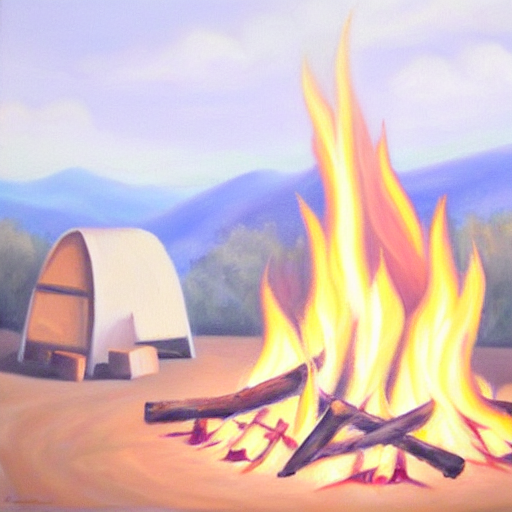

In [ ]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(
        images[:, 1] - 0.9
    )  # [:,2] -> all images in batch, only the blue channel
    error1 = torch.abs(images[:, 0] - 0.9)
    error2 = torch.abs(images[:, 1] - 0.9)
    error3 = torch.abs(images[:, 2] - 0.9)
    return (
        torch.sin(error1.mean()) + torch.sin(error2.mean()) + torch.sin(error3.mean())
    ) / 3


generate_image()

/tmp/ipykernel_1139061/3239947121.py:36: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  2%|▏         | 1/50 [00:00<00:17,  2.86it/s]

0 loss: 0.0


 22%|██▏       | 11/50 [00:03<00:13,  2.86it/s]

10 loss: 0.0


 42%|████▏     | 21/50 [00:06<00:10,  2.70it/s]

20 loss: 0.0


 62%|██████▏   | 31/50 [00:09<00:07,  2.64it/s]

30 loss: 0.0


 82%|████████▏ | 41/50 [00:12<00:03,  2.86it/s]

40 loss: 0.0


100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


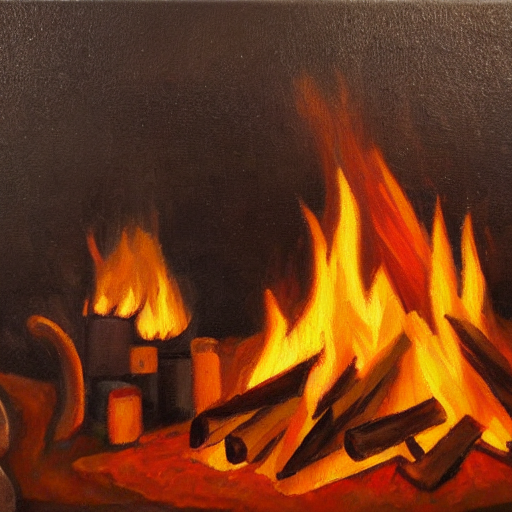

In [ ]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(
        images[:, 1] - 0.9
    )  # [:,2] -> all images in batch, only the blue channel
    error1 = torch.abs(images[:, 0] - 0.9)
    error2 = torch.abs(images[:, 1] - 0.9)
    error3 = torch.abs(images[:, 2] - 0.9)
    return 0.0 / error1.mean()


generate_image()